In [49]:
%matplotlib inline
import pandas as pd
import numpy as np
import ipywidgets as w
from ipywidgets import interact
import matplotlib.pyplot as plt

In [50]:
# COLLAPSE
# LONG COMPUTATION
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score, mean_squared_error
import numpy as np

def rmse(target, pred):
    return np.sqrt(mean_squared_error(target, pred))


def std_absolute_error(target, pred):
    return np.std(np.abs(target - pred))


def mapper(group):

    metrics = [mean_absolute_error, median_absolute_error, std_absolute_error, rmse, r2_score]
    
    # estes são para comparar com o `tickets`, dai levar um label 'T'
    # i_t
    group['case_TA'] = group['entries']
    group['case_TA_ns'] = group['entries_no_singles']
    
    # i_t as c_t - c_t-1 + o_t
    group['case_TB'] = group['current'] - group['current'].shift(1).fillna(0) + group['exits']
    group['case_TB_ns'] = group['current_no_singles'] - group['current_no_singles'].shift(1).fillna(0) \
                          + group['exits_no_singles'] 

    # estes são para comparar internamente para verificar a consistência dos dados wifi
    # comparando consigo mesmo, i.e. `macs_count`
    group['case_W'] = group['current']
    group['inner_W_ns'] = group['current_no_singles']
    
    res = pd.DataFrame()

    for i in ['TA', 'TA_ns', 'TB', 'TB_ns']:
        case = 'case_' + i
        for metric in metrics:
            res.loc[metric.__name__, case] = metric(group['tickets'], group[case])

    case = 'case_W'
    for metric in metrics:
        res.loc[metric.__name__, case] = metric(group['macs_count'], group[case])

    case = 'inner_W_ns'
    for metric in metrics:
        res.loc[metric.__name__, case] = metric(group['macs_count_no_singles'], group[case])

    res = res.transpose()
    res.index.name = 'case'
    
    return res

if False:
    metrics_results = df.groupby(['trip_id', 'min_rssi']).apply(mapper).reset_index().set_index('trip_id').join(
        bus_runs.reset_index()[
            ['router_id', 'route_nr', 'direction', 'trip_id', 'bus_id']
        ].set_index('trip_id')
    ).reset_index()
    metrics_results.to_pickle('.data/pickles/metrics_results_new.pkl')

In [110]:
# read data in
# and make few adjustments
# compilacao de contagens e bilhetica numa so tabela,
# com diferentes min_rssi
df = pd.read_pickle('.data/pickles/df_new.pkl').drop('mapping_method', axis=1).set_index(['trip_id', 'min_rssi'])

def mapper(group):
    # i_t as c_t - c_t-1 + o_t
    group['i_t'] = (group['current'] - group['current'].shift(1).fillna(0) + group['exits']).clip_lower(0)
    group['i_t_ns'] = (group['current_no_singles'] - group['current_no_singles'].shift(1).fillna(0) \
                          + group['exits_no_singles']).clip_lower(0)
    return group[['i_t', 'i_t_ns']]

df[['i_t', 'i_t_ns']] = df.groupby(level=['trip_id', 'min_rssi']).apply(mapper)
df = df.reset_index()

metrics_results = pd.read_pickle('report/metrics_results_new.pkl')
metrics_results['case'] = metrics_results['case'].replace(to_replace='inner_W_ns', value='case_W_ns')  # oops

# why not a join, you may ask
# it was duplicating lines with no reason whatsoever
trip_id2route_nr = metrics_results.groupby('trip_id').route_nr.unique().map(lambda x: x[0])
df['route_nr'] = df['trip_id'].map(lambda x: trip_id2route_nr.loc[x])
df = df.set_index('trip_id')

# para consulta
bus_runs = pd.read_pickle('.data/pickles/bus_runs.pkl')
bus_stops = pd.read_pickle('.data/pickles/bus_stops.pkl')

In [178]:
metrics_cols = ['mean_absolute_error', 'median_absolute_error', 'std_absolute_error', 'rmse', 'r2_score']
groupby_keys = ['case', 'route_nr', 'min_rssi']
mean_results = metrics_results.groupby(groupby_keys)[metrics_cols].mean()#[['rmse', 'r2_score']]

In [179]:
#metrics_results.to_excel('bytrip_results.xlsx')
#mean_results.to_excel('mean_results.xlsx')

In [180]:
#df.reset_index().to_csv('~/Desktop/df.csv')

In [54]:
trip_counts = df.reset_index().groupby('route_nr').trip_id.nunique().to_frame()  # quantas trips por route_nr
wil_have_coxon = trip_counts[trip_counts.trip_id > 20].index
trip_counts

trip_id
route_nr         
1             133
10              1
12             58
13             41
16             17
2              74
20              5
21             22
24              1
3               6
36             14
36A             1
38             15
4              22
44             11
45             64
47             54
48             62
49             19

In [55]:
choice = np.random.choice(df.reset_index().trip_id.unique())
#choice = 32145
print(choice)
ex = df.reset_index().set_index(['trip_id', 'min_rssi']).loc[choice].loc[-55]
ex['test'] = ex['entries'] - ex['exits']
ex['test'] += ex['test'].shift(1).fillna(0).astype(int)
ex['test'] = ex['test'].clip_lower(0).clip_upper(90)
print((ex['test'] == ex['current']).all())

ex['test'] = ex['entries_no_singles'] - ex['exits_no_singles']
ex['test'] += ex['test'].shift(1).fillna(0).astype(int)
ex['test'] = ex['test'].clip_lower(0).clip_upper(90)
(ex['test'] == ex['current_no_singles']).all()  # nem sempre da tudo True por causa do clip lower and upper ;)

ex['test'] = ex['current_no_singles'] - ex['current_no_singles'].shift(1).fillna(0) + ex['exits_no_singles']
(ex['test'] == ex['entries_no_singles']).value_counts()

21426
True


True     67
False     3
dtype: int64

In [56]:
mean_results.head(10)

mean_absolute_error  median_absolute_error  \
case    route_nr min_rssi                                               
case_TA 1        -85                  5.004243               1.676692   
                 -80                  3.710051               1.240602   
                 -75                  2.768433               0.868421   
                 -70                  2.084814               0.665414   
                 -65                  1.596565               0.507519   
                 -60                  1.255742               0.338346   
                 -55                  1.023909               0.195489   
                 none                 8.710917               2.992481   
        10       -85                  4.648649               0.000000   
                 -80                  2.918919               0.000000   

                           std_absolute_error       rmse    r2_score  
case    route_nr min_rssi                                             
case_TA 1        -85                 9.933570  11.241583  -79.838107  
                 -80                 7.200042   8.185030  -44.101428  
                 -75                 5.166089   5.917895  -23.072392  
                 -70                 3.748284   4.324931  -10.796495  
                 -65                 2.872197   3.311880   -5.092099  
                 -60                 2.344139   2.681222   -2.189809  
                 -55                 2.072744   2.333190   -0.639639  
                 none               17.139072  19.453974 -221.160863  
        10       -85                23.889629  24.337714  -20.604199  
                 -80                14.196266  14.493242   -6.661427

---
### escolha do min_rssi (A)

In [57]:
def mapper(group):
    result = group.reset_index().set_index( 
        'min_rssi'
    )[metrics_cols[:-1]].idxmin().apply(pd.Series).rename(
        {0:'min_rssi'}, axis=1
    )
    result.loc['r2_score'] = group.reset_index().set_index(
        'min_rssi'
    )['r2_score'].idxmax()
    result.index.name = 'metric'
    return result

optimal_params = mean_results.groupby(level=[
    'route_nr',
    'case'
]).apply(mapper)
optimal_params.head()

min_rssi
route_nr case    metric                        
1        case_TA mean_absolute_error        -55
                 median_absolute_error      -55
                 std_absolute_error         -55
                 rmse                       -55
                 r2_score                   -55

In [112]:
def mapper(group, top_head=3):
    res = group.min_rssi.value_counts(normalize=True).head(top_head).to_frame()
    res.index.name = 'min_rssi'
    res.columns = ['share']
    return res

#print('across all routes and metrics'); optimal_params.groupby('case').apply(mapper)
print('across all cases and metrics'); optimal_params.groupby('route_nr').apply(mapper, 1)
#print('across all routes and cases'); optimal_params.groupby('metric').apply(mapper)

across all cases and metrics


share
route_nr min_rssi          
1        -55       0.833333
10       -75       0.533333
12       -55       0.766667
13       -55       0.933333
16       -55       0.633333
2        -55       0.800000
20       -55       0.966667
21       -55       0.933333
24       -55       0.633333
3        -55       0.533333
36       -55       0.566667
36A      -80       0.400000
38       -55       0.633333
4        -55       0.933333
44       -55       0.900000
45       -55       0.833333
47       -55       0.766667
48       -55       0.833333
49       -55       0.933333

In [59]:
# for each route, select the best rssi globally
optimal_route_rssi = list(tuple(x[0]) for x in optimal_params.groupby('route_nr').apply(mapper, 1).iterrows())
selected_metrics_results = metrics_results.set_index(['route_nr', 'min_rssi']).loc[optimal_route_rssi].reset_index()

---
### discussao dos casos (B)

For the purposes of verifying the equations, we're **fixing the metric to RMSE** (as it penalizes greater errors by a quadratic order).

- [ ] discutir linha por linha como e que cada caso se comporta

In [60]:
smr = selected_metrics_results.set_index('case'); smr.head()

route_nr min_rssi  trip_id  mean_absolute_error  \
case                                                         
case_TA           1      -55     3813             0.653846   
case_TA_ns        1      -55     3813             0.576923   
case_TB           1      -55     3813             0.807692   
case_TB_ns        1      -55     3813             0.730769   
case_W            1      -55     3813             0.269231   

            median_absolute_error  std_absolute_error      rmse  r2_score  \
case                                                                        
case_TA                       0.0            2.147312  2.244652  0.099894   
case_TA_ns                    0.0            2.133489  2.210117  0.127378   
case_TB                       0.0            2.166515  2.312175  0.044926   
case_TB_ns                    0.0            2.158306  2.278664  0.072410   
case_W                        0.0            0.443560  0.518875  0.505435   

            router_id direction  bus_id  
case                                     
case_TA          1002       ASC     405  
case_TA_ns       1002       ASC     405  
case_TB          1002       ASC     405  
case_TB_ns       1002       ASC     405  
case_W           1002       ASC     405

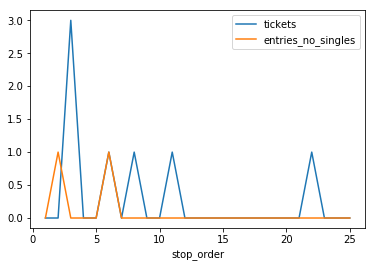

In [61]:
ex = df[df.min_rssi == -55].loc[12867]  # honestly. no fucking idea what happened
ex.set_index('stop_order')[['tickets', 'entries_no_singles']].plot()

In [62]:
smr[smr.route_nr == '1'].loc['case_TA_ns'].set_index('trip_id').sort_values('mean_absolute_error', ascending=True)

route_nr min_rssi  mean_absolute_error  median_absolute_error  \
trip_id                                                                 
12859          1      -55             0.153846                    0.0   
23696          1      -55             0.192308                    0.0   
12867          1      -55             0.280000                    0.0   
12815          1      -55             0.280000                    0.0   
12883          1      -55             0.307692                    0.0   
3960           1      -55             0.307692                    0.0   
3939           1      -55             0.307692                    0.0   
4222           1      -55             0.320000                    0.0   
12845          1      -55             0.346154                    0.0   
4043           1      -55             0.346154                    0.0   
12909          1      -55             0.360000                    0.0   
4220           1      -55             0.360000                    0.0   
12835          1      -55             0.384615                    0.0   
4200           1      -55             0.384615                    0.0   
12882          1      -55             0.400000                    0.0   
12799          1      -55             0.400000                    0.0   
8476           1      -55             0.423077                    0.0   
4116           1      -55             0.440000                    0.0   
4068           1      -55             0.440000                    0.0   
12821          1      -55             0.440000                    0.0   
3897           1      -55             0.461538                    0.0   
4268           1      -55             0.461538                    0.0   
12866          1      -55             0.480000                    0.0   
12910          1      -55             0.480000                    0.0   
4088           1      -55             0.500000                    0.0   
3876           1      -55             0.500000                    0.0   
4219           1      -55             0.520000                    0.0   
12807          1      -55             0.520000                    0.0   
12783          1      -55             0.520000                    0.0   
12917          1      -55             0.520000                    0.0   
...          ...      ...                  ...                    ...   
3900           1      -55             1.120000                    0.0   
4093           1      -55             1.160000                    0.0   
12784          1      -55             1.192308                    0.0   
12849          1      -55             1.200000                    0.0   
3982           1      -55             1.230769                    0.5   
12804          1      -55             1.240000                    0.0   
12868          1      -55             1.269231                    0.0   
3815           1      -55             1.269231                    0.0   
12848          1      -55             1.269231                    0.0   
3941           1      -55             1.307692                    0.0   
4045           1      -55             1.307692                    0.0   
12837          1      -55             1.320000                    0.0   
4009           1      -55             1.360000                    0.0   
4181           1      -55             1.384615                    0.0   
4118           1      -55             1.384615                    0.0   
4182           1      -55             1.400000                    1.0   
4090           1      -55             1.423077                    0.0   
12839          1      -55             1.423077                    1.0   
3942           1      -55             1.440000                    1.0   
4160           1      -55             1.461538                    0.0   
12813          1      -55             1.520000                    0.0   
4270           1      -55             1.538462                    

---
#### caso A: tickets vs in's

$b_t$ vs $i_t$

[wilcoxon test](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.wilcoxon.html#scipy.stats.wilcoxon)

In [63]:
from scipy.stats import wilcoxon

In [64]:
def mapper(group):
    return group.reset_index().set_index('case')['mean'].idxmin()

caso_TA_gen = smr.loc[['case_TA', 'case_TA_ns']].reset_index().groupby(
    ['route_nr', 'case']
).rmse.agg([np.mean, np.std])
caso_TA_min_mean = caso_TA_gen.groupby(['route_nr']).apply(mapper).value_counts().to_frame().rename({0: 'min_mean'}, axis=1)

In [65]:
def mapper_2(group):
    # este mapper retorna o case em que o rmse e minimizado para a linha em questao
    # e o pvalue a comprovar se ha diference entre randoms e nao randoms ('ns')
    idxmin = group.reset_index().set_index('case')['mean'].idxmin()
    
    resies = smr.loc[['case_TA', 'case_TA_ns']].reset_index()[['case', 'rmse', 'trip_id']].set_index(['case', 'trip_id']).sort_index()
    sample_a = resies.loc['case_TA'].values.flatten()
    sample_b = resies.loc['case_TA_ns'].values.flatten()
    wilcox_pval = wilcoxon(sample_a, sample_b).pvalue
    return pd.Series(data=[idxmin, wilcox_pval], index=['case', 'wilcox_pval'])

caso_TA_gen.groupby(['route_nr']).apply(mapper_2).loc[wil_have_coxon]

case   wilcox_pval
route_nr                          
1         case_TA_ns  8.189422e-08
12        case_TA_ns  8.189422e-08
13        case_TA_ns  8.189422e-08
2         case_TA_ns  8.189422e-08
21        case_TA_ns  8.189422e-08
4         case_TA_ns  8.189422e-08
45        case_TA_ns  8.189422e-08
47        case_TA_ns  8.189422e-08
48        case_TA_ns  8.189422e-08

In [66]:
caso_TA_gen.head()

mean       std
route_nr case                          
1        case_TA     2.333190  1.424631
         case_TA_ns  2.199994  1.467725
10       case_TA     8.529757       NaN
         case_TA_ns  1.823273       NaN
12       case_TA     1.849060  0.765542

In [67]:
caso_TA_min_mean

min_mean
case_TA_ns        17
case_TA            2

---
#### caso B: tickets vs analytically equivalent in's

$b_t$ vs $c_t - c_{t-1} + o_t$ (a substitution for $i_t$)

In [68]:
def mapper(group):
    return group.reset_index().set_index('case')['mean'].idxmin()

caso_TB_gen = smr.loc[['case_TB', 'case_TB_ns']].reset_index().groupby(
    ['route_nr', 'case']
).rmse.agg([np.mean, np.std])
caso_TB_min_mean = caso_TB_gen.groupby(['route_nr']).apply(mapper).value_counts().to_frame().rename({0: 'min_mean'}, axis=1)

In [69]:
def mapper_2(group):
    # este mapper retorna o case em que o rmse e minimizado para a linha em questao
    # e o pvalue a comprovar se ha diference entre randoms e nao randoms ('ns')
    idxmin = group.reset_index().set_index('case')['mean'].idxmin()
    
    resies = smr.loc[['case_TB', 'case_TB_ns']].reset_index()[['case', 'rmse', 'trip_id']].set_index(['case', 'trip_id']).sort_index()
    sample_a = resies.loc['case_TB'].values.flatten()
    sample_b = resies.loc['case_TB_ns'].values.flatten()
    wilcox_pval = wilcoxon(sample_a, sample_b).pvalue
    return pd.Series(data=[idxmin, wilcox_pval], index=['case', 'wilcox_pval'])

caso_TB_gen.groupby(['route_nr']).apply(mapper_2).loc[wil_have_coxon]

case   wilcox_pval
route_nr                          
1         case_TB_ns  2.313602e-07
12        case_TB_ns  2.313602e-07
13        case_TB_ns  2.313602e-07
2         case_TB_ns  2.313602e-07
21        case_TB_ns  2.313602e-07
4         case_TB_ns  2.313602e-07
45        case_TB_ns  2.313602e-07
47        case_TB_ns  2.313602e-07
48        case_TB_ns  2.313602e-07

In [70]:
caso_TB_gen.head()  # fazer smirnov-kolmogorov?

mean       std
route_nr case                          
1        case_TB     2.435923  1.443185
         case_TB_ns  2.286841  1.467240
10       case_TB     8.529757       NaN
         case_TB_ns  1.823273       NaN
12       case_TB     1.983132  0.774997

In [71]:
caso_TB_min_mean

min_mean
case_TB_ns        17
case_TB            2

---
#### caso W
$w_t$ vs $c_t$

In [72]:
def mapper(group):
    return group.reset_index().set_index('case')['mean'].idxmin()

caso_W_gen = smr.loc[['case_W', 'case_W_ns']].reset_index().groupby(
    ['route_nr', 'case']
).rmse.agg([np.mean, np.std])
caso_W_min_mean = caso_W_gen.groupby(['route_nr']).apply(mapper).value_counts().to_frame().rename({0: 'min_mean'}, axis=1)

In [73]:
def mapper_2(group):
    # este mapper retorna o case em que o rmse e minimizado para a linha em questao
    # e o pvalue a comprovar se ha diference entre randoms e nao randoms ('ns')
    idxmin = group.reset_index().set_index('case')['mean'].idxmin()
    
    resies = smr.loc[['case_W', 'case_W_ns']].reset_index()[['case', 'rmse', 'trip_id']].set_index(['case', 'trip_id']).sort_index()
    sample_a = resies.loc['case_W'].values.flatten()
    sample_b = resies.loc['case_W_ns'].values.flatten()
    wilcox_pval = wilcoxon(sample_a, sample_b).pvalue
    return pd.Series(data=[idxmin, wilcox_pval], index=['case', 'wilcox_pval'])

caso_W_gen.groupby(['route_nr']).apply(mapper_2).loc[wil_have_coxon]

case   wilcox_pval
route_nr                         
1         case_W_ns  2.689899e-43
12        case_W_ns  2.689899e-43
13        case_W_ns  2.689899e-43
2         case_W_ns  2.689899e-43
21        case_W_ns  2.689899e-43
4         case_W_ns  2.689899e-43
45        case_W_ns  2.689899e-43
47        case_W_ns  2.689899e-43
48        case_W_ns  2.689899e-43

In [74]:
caso_W_min_mean

min_mean
case_W_ns        15
case_W            4

---
#### etapa C :: discutir performance linha a linha

usando os -55 e o ns

In [75]:
# tendo determinado min_rssi -55 e no-singles (ns)
# discutir performance linha a linha
param_select = metrics_results.set_index(['route_nr', 'min_rssi']).loc[optimal_route_rssi].reset_index().set_index(
    'case'
).loc[['case_TA_ns', 'case_TB_ns', 'case_W_ns']]

In [76]:
# final results I guess?
# as metricas aqui foram escolhidas para interpretibilidade e nao para optimizacao
fins = param_select.groupby(['route_nr', 'case'])[
    ['mean_absolute_error', 'std_absolute_error']
].mean()

In [77]:
routes = fins.index.levels[0]
orr = pd.DataFrame(optimal_route_rssi).set_index(0)

@interact(route=routes)
def julie_do_the_thing(route):
    opt_rssi = orr.loc[route].values[0]
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25.2, 5.5))
    fig.suptitle(
        'Route ' + route + ' with min_rssi = ' + str(opt_rssi),
        size=18
    )
    fins.loc[route].plot.bar(ax=ax[0], title='Performance accross cases')

    plt.figtext(
        x=.8,
        y=0,
        s='[# unique trip_ids] = ' + str(trip_counts.loc[route].trip_id),
        #horizontalalignment='right'
        size=14
    )
    
    try:
        best = param_select.loc['case_TA_ns'].set_index('route_nr').loc[route].set_index('trip_id')['mean_absolute_error'].idxmin()
        worst = param_select.loc['case_TA_ns'].set_index('route_nr').loc[route].set_index('trip_id')['mean_absolute_error'].idxmax()
    except:
        best = param_select.loc['case_TA_ns'].set_index('route_nr').loc[route].trip_id
        worst = best
    
    dfo = df[df.min_rssi == opt_rssi]
    dfo.loc[best].set_index('stop_order')[['tickets', 'entries_no_singles']].plot(ax=ax[1], title='Best performing on MAE :: trip_id ' + str(best))
    dfo.loc[worst].set_index('stop_order')[['tickets', 'entries_no_singles']].plot(ax=ax[2], title='Worst performing on MAE :: trip_id ' + str(worst))

interactive(children=(Dropdown(description='route', options=('1', '10', '12', '13', '16', '2', '20', '21', '24…

In [82]:
metrics_results.case.unique()

array(['case_TA', 'case_TA_ns', 'case_TB', 'case_TB_ns', 'case_W',
       'case_W_ns'], dtype=object)

In [84]:
choose_cols = {
    'case_TA': ['tickets', 'entries'],
    'case_TA_ns': ['tickets', 'entries_no_singles'],
    'case_TB': ['tickets', 'i_t'],
    'case_TB_ns': ['tickets', 'i_t_ns'],
    'case_W': ['macs_count', 'current'],
    'case_W_ns': ['macs_count_no_singles', 'current_no_singles']
}

In [109]:
@interact(trip_id=df.index.unique().sort_values(), rssi=df.min_rssi.unique(), case=metrics_results.case.unique())
def what_thing(trip_id, rssi, case):
    df[df.min_rssi == rssi].loc[trip_id].set_index('stop_order')[choose_cols[case]].plot(title='case_TA_ns')
    print(bus_runs.reset_index().set_index('trip_id')[['route_nr', 'trip_nr', 'direction', 'trip_start', 'trip_end', 'router_id', 'bus_id']].loc[trip_id])
    #return metrics_results.set_index(['trip_id', 'min_rssi']).loc[trip_id].loc[rssi]
    return metrics_results.set_index(['trip_id', 'case']).loc[trip_id].loc[case]

interactive(children=(Dropdown(description='trip_id', options=(3813, 3814, 3815, 3816, 3818, 3834, 3835, 3855,…

In [125]:
metrics_results.set_index(['case']).loc[[
    'case_TA_ns', 
    #'case_TB_ns', 
    'case_W_ns'
]].reset_index().set_index(
    ['route_nr', 'min_rssi']
).loc[optimal_route_rssi].reset_index().groupby([
    'route_nr',
    'case'
])[metrics_cols].mean().loc[wil_have_coxon][['mean_absolute_error', 'rmse', 'r2_score']]

mean_absolute_error      rmse   r2_score
route_nr case                                                
1        case_TA_ns             0.858176  2.199994  -0.150786
         case_W_ns              0.206261  0.431653   0.241713
12       case_TA_ns             0.763003  1.638572  -0.277664
         case_W_ns              0.682559  0.933435  -0.673046
13       case_TA_ns             1.001721  2.318764 -59.722036
         case_W_ns              1.173905  1.506101  -0.606602
2        case_TA_ns             1.218691  2.619173  -0.113846
         case_W_ns              0.470244  0.837440   0.208874
21       case_TA_ns             0.948865  2.455335  -0.806892
         case_W_ns              1.521343  1.878233  -1.393809
4        case_TA_ns             1.058923  2.806111   0.019257
         case_W_ns              0.557239  0.897014   0.021447
45       case_TA_ns             0.858693  1.676111  -0.047914
         case_W_ns              0.580035  0.818562  -0.563264
47       case_TA_ns             0.465915  1.687688  -0.213603
         case_W_ns              0.653032  0.864398  -0.769757
48       case_TA_ns             0.599757  1.289090  -0.147771
         case_W_ns              0.533048  0.818457  -0.325276

In [151]:
from scipy.stats import sem, t
from scipy import mean

def t_dist_ci(data, bound, confidence=.95):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + confidence) / 2, n - 1)

    if bound == 'lower':
        lower = m - h
        return lower
    elif bound == 'upper':
        upper = m + h
        return upper
    else:
        raise

In [161]:
gb = metrics_results.set_index(['case']).loc[[
    'case_TA_ns', 
    #'case_TB_ns', 
    'case_W_ns'
]].reset_index().set_index(
    ['route_nr', 'min_rssi']
).loc[optimal_route_rssi].reset_index().groupby([
    'route_nr',
    'case'
])['r2_score']

lower = gb.apply(t_dist_ci, 'lower')
upper = gb.apply(t_dist_ci, 'upper')
res = gb.describe()

res['upper_ci'] = upper
res['lower_ci'] = lower

res = res[res['count'] >= 30]  # o minimo aceitavel para o t test
res['count'] = res['count'].astype(int)

In [174]:
gb = metrics_results.set_index(['case']).loc[[
    'case_TA_ns', 
    #'case_TB_ns', 
    #'case_W_ns'
]].reset_index().groupby([
    'route_nr',
    'case',
    'min_rssi'
])['r2_score']

lower = gb.apply(t_dist_ci, 'lower')
upper = gb.apply(t_dist_ci, 'upper')
res = gb.describe()

res['upper_ci'] = upper
res['lower_ci'] = lower

res = res[res['count'] >= 30]  # o minimo aceitavel para o t test
res['count'] = res['count'].astype(int)

In [175]:
res[['lower_ci', 'upper_ci', 'count', 'mean', 'std']]

lower_ci      upper_ci  count          mean  \
route_nr case       min_rssi                                                    
1        case_TA_ns -85          -4.103591     -0.758781    133     -2.431186   
                    -80          -2.582716     -0.219392    133     -1.401054   
                    -75          -0.854179     -0.204450    133     -0.529314   
                    -70          -0.330189     -0.127138    133     -0.228663   
                    -65          -0.185968     -0.068629    133     -0.127299   
                    -60          -0.158176     -0.067308    133     -0.112742   
                    -55          -0.188954     -0.112617    133     -0.150786   
                    none         -7.311294     -1.861802    133     -4.586548   
12       case_TA_ns -85         -39.608212     -2.064665     58    -20.836438   
                    -80         -18.669452     -1.656364     58    -10.162908   
                    -75          -8.653275     -1.004101     58     -4.828688   
                    -70          -3.499459     -0.404504     58     -1.951981   
                    -65          -1.625406     -0.101866     58     -0.863636   
                    -60          -0.684698     -0.033979     58     -0.359338   
                    -55          -0.436996     -0.118331     58     -0.277664   
                    none        -96.375039     -1.102084     58    -48.738562   
13       case_TA_ns -85      -23204.616756   4538.374720     41  -9333.121018   
                    -80      -11633.008939   2234.068118     41  -4699.470411   
                    -75       -5632.070427   1068.122360     41  -2281.974033   
                    -70       -2813.913102    540.966159     41  -1136.473471   
                    -65       -1170.203707    216.189084     41   -477.007311   
                    -60        -449.341571     77.803785     41   -185.768893   
                    -55        -143.680461     24.236389     41    -59.722036   
                    none     -56416.523578  12012.654958     41 -22201.934310   
2        case_TA_ns -85         -15.240509     -4.317874     74     -9.779191   
                    -80          -8.129157     -1.927983     74     -5.028570   
                    -75          -3.728820     -0.514244     74     -2.121532   
                    -70          -1.442529     -0.000349     74     -0.721439   
                    -65          -0.752509      0.161444     74     -0.295532   
                    -60          -0.407936      0.103799     74     -0.152069   
                    -55          -0.191506     -0.036187     74     -0.113846   
                    none        -35.541804     -7.576874     74    -21.559339   
45       case_TA_ns -85          -4.508187     -0.946554     64     -2.727370   
                    -80          -2.555464     -0.306690     64     -1.431077   
                    -75          -1.133684     -0.095344     64     -0.614514   
                    -70          -0.477481      0.106434     64     -0.185524   
                    -65          -0.219827      0.105675     64     -0.057076   
                    -60          -0.125911      0.067934     64     -0.028988   
                    -55          -0.142865      0.047038     64     -0.047914   
                    none        -10.204225     -2.480562     64     -6.342393   
47       case_TA_ns -85        -166.168240    -45.645164     54   -105.906702   
                    -80         -76.576745    -18.324766     54    -47.450755   
                    -75         -30.386921     -6.603843     54    -18.495382   
                    -70          -8.228737     -1.687359     54     -4.958048   
                    -65          -2.611033     -0.460166     54     -1.535599   
                    -60          -0.568828     -0.123870     54     -0.346349   
                    -55          -0.361765     -0.065441     54     -0.213603   
                    none       -353.514718    -94.029835     54  

In [108]:
for route in routes:
    #julie_do_the_thing(route)  # plot it
    continue